In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [9]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
time_expector = TimeExpector()

In [10]:
batch_size = 4
nb_epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

test_run = True
if test_run:
    print('[WARNING] : This is test run.')

[WARNING] : This is test run.


In [11]:
# FIXME
my_laptop = True
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    if test_run:
        trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])
for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

pre-processing dataset: 175
pre-processing dataset: 175


In [12]:
def plot_one_batch(network):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
            if l.HAS_PARAM:
                plot_spikes_in_time(l)

In [13]:
from scnn.default_configs import *


class MyConv3d(torch.nn.Module):
    IS_CONV = True
    IS_SPIKING = True
    HAS_PARAM = True

    def __init__(self, input_shape, input_channels, output_shape=None,
                 output_channels=1, kernel_size=3, dilation=1,
                 spike_fn=None, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD, recurrent=False,
                 lateral_connections=True,
                 eps=EPSILON, stride=(1, 1, 1), flatten_output=False):

        super(MyConv3d, self).__init__()

        self.kernel_size = np.array(kernel_size)
        self.dilation = np.array(dilation)
        self.stride = np.array(stride)
        self.input_channels = input_channels
        self.input_shape = input_shape

        self.output_channels = output_channels
        self.output_shape = output_shape if output_shape is not None else input_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.lateral_connections = lateral_connections
        self.eps = eps

        self.flatten_output = flatten_output

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((output_channels, input_channels, *kernel_size)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_channels, output_channels)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_channels), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

        # TODO : check this
        tau_mem = 10e-3
        tau_syn = 5e-3
        time_step = 1e-3
        self._alpha = float(np.exp(-time_step / tau_syn))
        self._beta = float(np.exp(-time_step / tau_mem))

    def get_trainable_parameters(self):
        res = [
            {'params': self.w},  #, 'lr': lr, "weight_decay": DEFAULT_WEIGHT_DECAY}
            {'params': self.b},
            {'params': self.beta},
        ]

        if self.recurrent:
            res.append({'params': self.v})
        return res

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[2]
        
        stride = tuple(self.stride)
        padding = tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
        conv_x = torch.nn.functional.conv3d(x, self.w, padding=padding,
                                            dilation=tuple(self.dilation),
                                            stride=stride)
        conv_x = conv_x[:, :, :, :self.output_shape[0], :self.output_shape[1]]

        mem = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)
        syn = torch.zeros((batch_size, self.output_channels, *self.output_shape), device=x.device, dtype=x.dtype)  # FIXME
        spk = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)

        spk_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)
        mem_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)

        if self.lateral_connections:
            d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
        b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

        norm = (self.w ** 2).sum((1, 2, 3, 4))

        for t in range(nb_steps):
            # spike term
            # mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            # spk = self.spike_fn(mthr)

            if self.lateral_connections:
                rst = torch.einsum("abcd,be ->aecd", spk, d)
            else:
                rst = torch.einsum("abcd,b,b->abcd", spk, self.b, norm)

            input_ = conv_x[:, :, t, :, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("abcd,be->aecd", spk, self.v)

            # TODO : check to see if this is actually works
            new_syn = self._alpha * syn + input_
            new_mem = self._beta * mem + syn - rst
            mem = new_mem
            syn = new_syn
            # mem = (mem - rst) * self.beta + input_ * (1. - self.beta)

            mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            spk = self.spike_fn(mthr)

            spk_rec[:, :, t, :, :] = spk
            mem_rec[:, :, t, :, :] = mem

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()

        if self.flatten_output:
            output = torch.transpose(spk_rec, 1, 2).contiguous()
            output = output.view(batch_size, nb_steps, self.output_channels * np.prod(self.output_shape))
        else:
            output = spk_rec

        return output

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / (self.input_channels * np.prod(self.kernel_size))))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean,
                                  std=self.w_init_std * np.sqrt(1. / self.output_channels))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)


In [14]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)

# network.add_dense( #layer(LegacyDense,
#     input_shape=4096,
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

# network.add_layer(NewSpiker,
#     input_shape=4096,
#     output_shape=128,
                  
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_layer(MyConv3d, #conv3d(
    input_shape=(64,64),
    
    output_channels=16,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    
    w_init_mean=1.0,
    w_init_std=0.01
)

network.add_pool2d(kernel_size=(4,4))


# network.add_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# #     lateral_connections=True
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

Layer 1: average number of spikes=0.1709


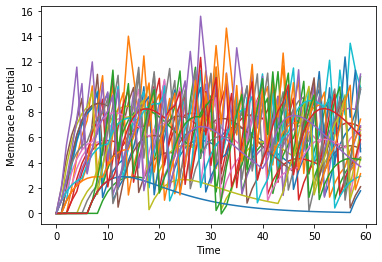

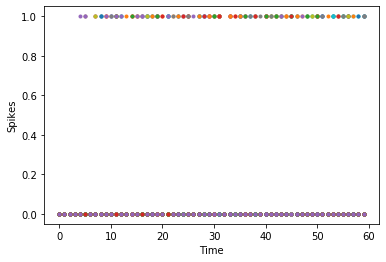

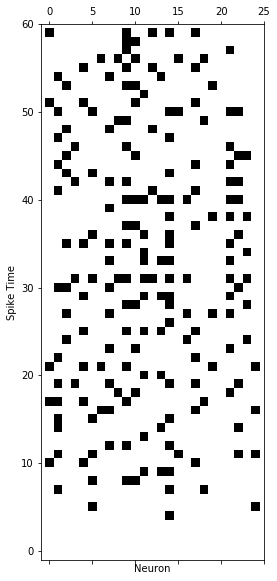

<Figure size 2160x1440 with 0 Axes>

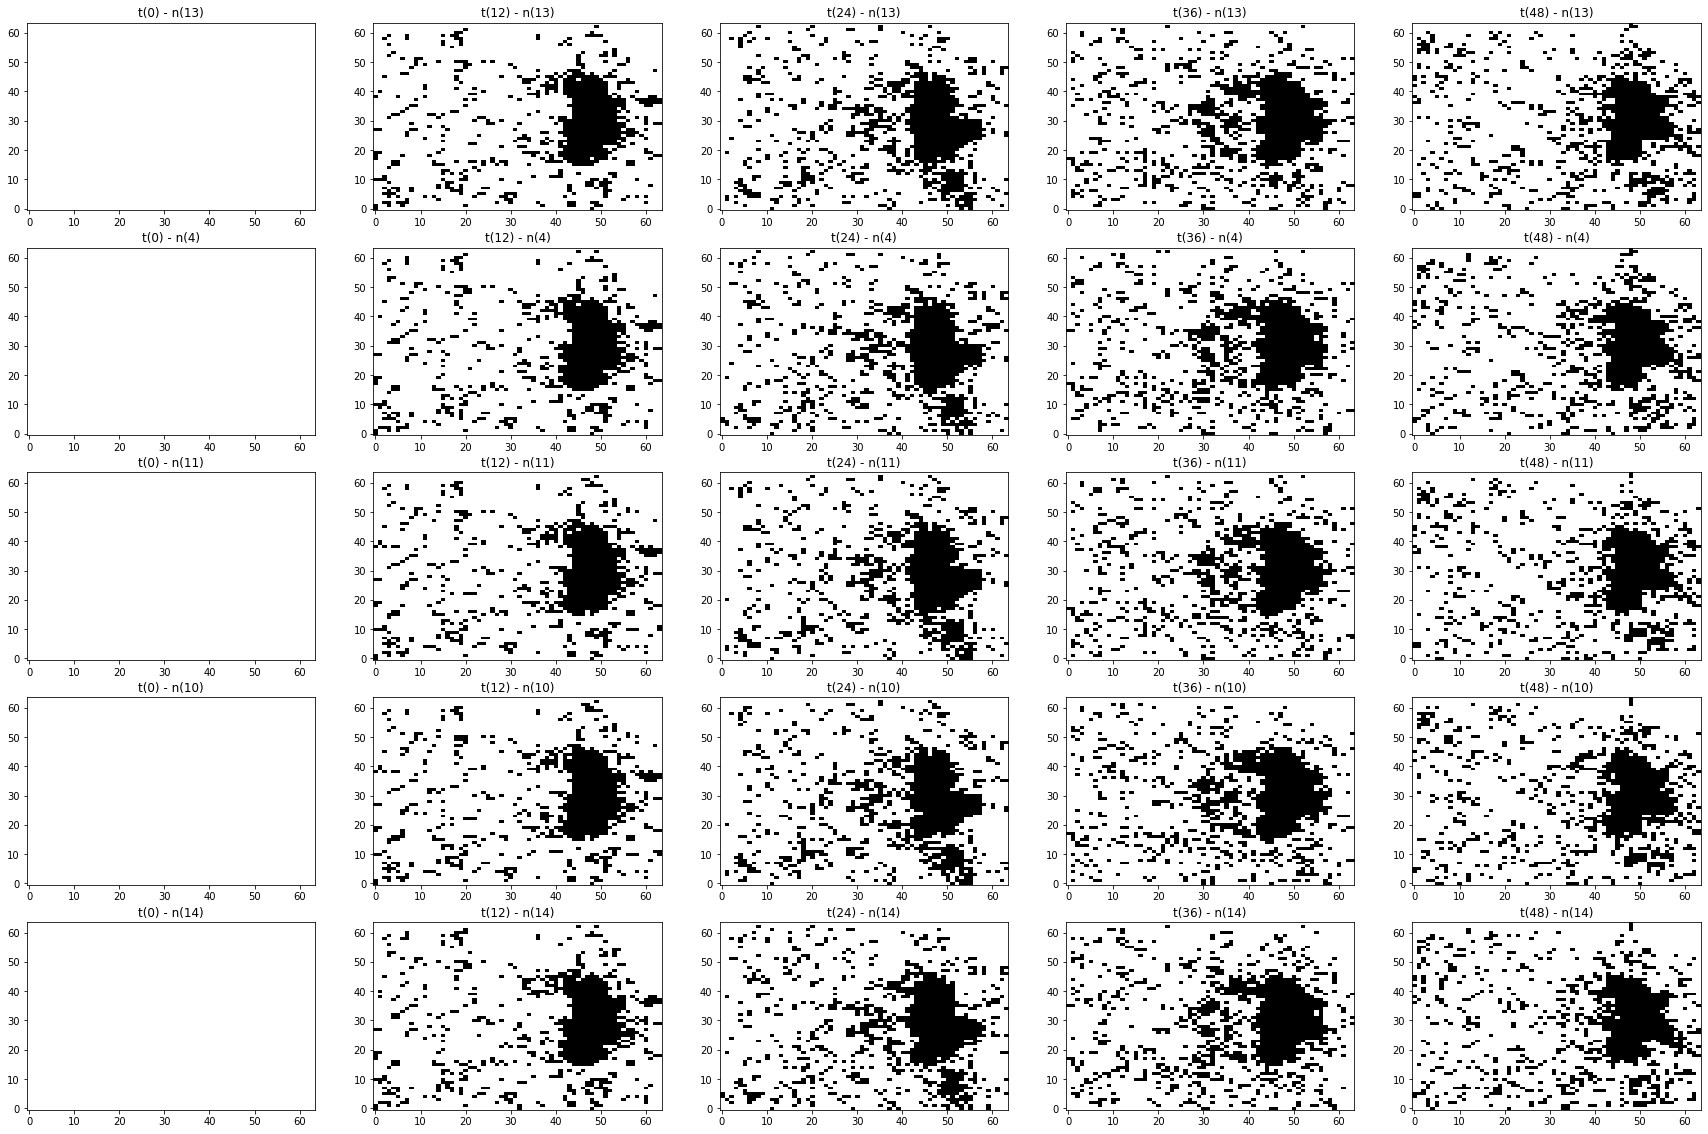

Layer 2: average number of spikes=0.5006

----------------------------------------
Final Train Accuracy=4.71%
Final Test Accuracy=4.71%


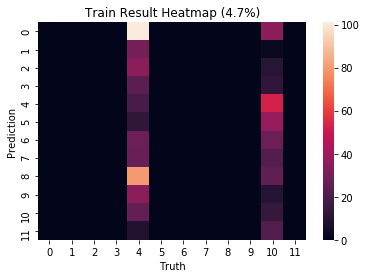

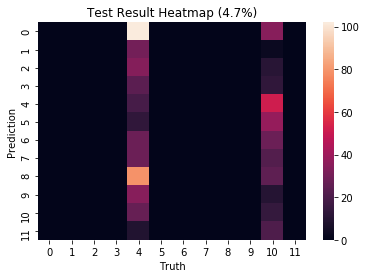

In [15]:
plot_one_batch(network)
print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))

In [16]:
with open('results.log', 'w') as f:
    # opt = RAdam(network.get_trainable_parameters())
    opt = torch.optim.SGD(network.get_trainable_parameters(), lr=1e-3, momentum=0.9)
    network.fit(load_data, epochs=nb_epochs, optimizer=opt, dataset_size=dataset_size, result_file=f)

network.save('save_network.net')
# network.load('save_network.net')

Epoch: 0 [>...........................................................] 1%    

KeyboardInterrupt: 

In [ ]:
plot_one_batch(network)
print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))

In [ ]:
for b in range(batch_size):
    for i in range(12):
        plt.plot(network.layers[-1].mem_rec_hist[b,:,i])
    plt.show()

In [ ]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)